In [ ]:
import yfinance as yf
import datetime as dt
from datetime import datetime, timedelta
import scipy
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import os
import requests


In [4]:
def get_spx_tickers():
    spx_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    return spx_tickers['Symbol'].tolist()

def get_upcoming_earnings(tickers, days=6):
    ticker_earnings = {}
    for ticker in tickers:
        range_dates = []
        stock = yf.Ticker(ticker)
        earnings_dates = list(stock.earnings_dates.sort_index().index) if stock.earnings_dates is not None else []
        for date in earnings_dates:
            if (dt.datetime.now() < dt.datetime(date.year, date.month, date.day) < (dt.datetime.now() + dt.timedelta(days=days))):
                range_dates.append(date)
        upcoming_event = range_dates[0] if range_dates else None
        if upcoming_event:
            ticker_earnings[ticker] = upcoming_event.to_pydatetime()
    return ticker_earnings

In [5]:
def filter_dates(dates):
    today = datetime.today().date()
    cutoff_date = today + timedelta(days=45)
    
    sorted_dates = sorted(datetime.strptime(date, "%Y-%m-%d").date() for date in dates)

    arr = []
    for i, date in enumerate(sorted_dates):
        if date >= cutoff_date:
            arr = [d.strftime("%Y-%m-%d") for d in sorted_dates[:i+1]]  
            break
    
    if len(arr) > 0:
        if arr[0] == today.strftime("%Y-%m-%d"):
            return arr[1:]
        return arr

    raise ValueError("No date 45 days or more in the future found.")


def yang_zhang(price_data, window=30, trading_periods=252, return_last_only=True):
    log_ho = (price_data['High'] / price_data['Open']).apply(np.log)
    log_lo = (price_data['Low'] / price_data['Open']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)
    
    log_oc = (price_data['Open'] / price_data['Close'].shift(1)).apply(np.log)
    log_oc_sq = log_oc**2
    
    log_cc = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)
    log_cc_sq = log_cc**2
    
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
    
    close_vol = log_cc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))

    open_vol = log_oc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))

    window_rs = rs.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + ((window + 1) / (window - 1)) )
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * np.sqrt(trading_periods)

    if return_last_only:
        return result.iloc[-1]
    else:
        return result.dropna()
    

def build_term_structure(days, ivs):
    days = np.array(days)
    ivs = np.array(ivs)

    sort_idx = days.argsort()
    days = days[sort_idx]
    ivs = ivs[sort_idx]

    spline = interp1d(days, ivs, kind='linear', fill_value="extrapolate")

    def term_spline(dte):
        if dte < days[0]:  
            return ivs[0]
        elif dte > days[-1]:
            return ivs[-1]
        else:  
            return float(spline(dte))

    return term_spline

def get_current_price(ticker):
    todays_data = ticker.history(period='1d')
    if todays_data.empty:
        raise ValueError("No market data available for today.")
    return todays_data['Close'].iloc[0]

def compute_recommendation(tickers):
    if isinstance(tickers, str):
        tickers = [tickers]
    
    recommendations = {}
    
    for ticker in tickers:
        try:
            ticker = ticker.strip().upper()
            if not ticker:
                recommendations[ticker] = "No stock symbol provided."
                continue
            
            try:
                stock = yf.Ticker(ticker)
                if len(stock.options) == 0:
                    raise KeyError()
            except KeyError:
                recommendations[ticker] = f"Error: No options found for stock symbol '{ticker}'."
                continue
            
            exp_dates = list(stock.options)
            try:
                exp_dates = filter_dates(exp_dates)
            except:
                recommendations[ticker] = "Error: Not enough option data."
                continue
            
            options_chains = {}
            for exp_date in exp_dates:
                options_chains[exp_date] = stock.option_chain(exp_date)
            
            try:
                underlying_price = get_current_price(stock)
                if underlying_price is None:
                    raise ValueError("No market price found.")
            except Exception:
                recommendations[ticker] = "Error: Unable to retrieve underlying stock price."
                continue
            
            atm_iv = {}
            straddle = None 
            i = 0
            for exp_date, chain in options_chains.items():
                calls = chain.calls
                puts = chain.puts

                if calls.empty or puts.empty:
                    continue

                call_diffs = (calls['strike'] - underlying_price).abs()
                call_idx = call_diffs.idxmin()
                call_iv = calls.loc[call_idx, 'impliedVolatility']

                put_diffs = (puts['strike'] - underlying_price).abs()
                put_idx = put_diffs.idxmin()
                put_iv = puts.loc[put_idx, 'impliedVolatility']

                atm_iv_value = (call_iv + put_iv) / 2.0
                atm_iv[exp_date] = atm_iv_value

                if i == 0:
                    call_bid = calls.loc[call_idx, 'bid']
                    call_ask = calls.loc[call_idx, 'ask']
                    put_bid = puts.loc[put_idx, 'bid']
                    put_ask = puts.loc[put_idx, 'ask']
                    
                    if call_bid is not None and call_ask is not None:
                        call_mid = (call_bid + call_ask) / 2.0
                    else:
                        call_mid = None

                    if put_bid is not None and put_ask is not None:
                        put_mid = (put_bid + put_ask) / 2.0
                    else:
                        put_mid = None

                    if call_mid is not None and put_mid is not None:
                        straddle = (call_mid + put_mid)

                i += 1
            
            if not atm_iv:
                recommendations[ticker] = "Error: Could not determine ATM IV for any expiration dates."
                continue
            
            today = datetime.today().date()
            dtes = []
            ivs = []
            for exp_date, iv in atm_iv.items():
                exp_date_obj = datetime.strptime(exp_date, "%Y-%m-%d").date()
                days_to_expiry = (exp_date_obj - today).days
                dtes.append(days_to_expiry)
                ivs.append(iv)
            
            term_spline = build_term_structure(dtes, ivs)
            
            ts_slope_0_45 = (term_spline(45) - term_spline(dtes[0])) / (45-dtes[0])
            
            price_history = stock.history(period='3mo')
            iv30_rv30 = term_spline(30) / yang_zhang(price_history)

            avg_volume = price_history['Volume'].rolling(30).mean().dropna().iloc[-1]

            expected_move = round(straddle / underlying_price * 100,2) if straddle else None

            recommendations[ticker] = {'avg_volume': avg_volume >= 1500000, 'iv30_rv30': iv30_rv30 >= 1.25, 'ts_slope_0_45': ts_slope_0_45 <= -0.00406, 'expected_move': expected_move} #Check that they are in our desired range (see video)
        except Exception as e:
            recommendations[ticker] = f'Error occurred processing {ticker}: {str(e)}'
    
    return recommendations

def is_recommended(ticker_dict):
    for ticker, data in ticker_dict.items():
        avg_volume_bool = data['avg_volume']
        iv30_rv30_bool = data['iv30_rv30']
        ts_slope_bool = data['ts_slope_0_45']

        if avg_volume_bool and iv30_rv30_bool and ts_slope_bool:
            ticker_dict[ticker] = {"Recommendation": "Recommended"}
        elif ts_slope_bool and (avg_volume_bool or iv30_rv30_bool):
            ticker_dict[ticker] = {"Recommendation": "Consider"}
        else:
            ticker_dict[ticker] = None
    
    return ticker_dict
    
def process_tickers(tickers):
    results = compute_recommendation(tickers)
    recommendations = is_recommended(results)
    recommendations = {ticker: rec for ticker, rec in recommendations.items() if rec is not None}
    return recommendations

In [6]:
def find_nearest_expiration(expirations, target_date):
    target_date = target_date.replace(tzinfo=None)
    return min(expirations, key=lambda x: abs(datetime.strptime(x, '%Y-%m-%d') - target_date))

def find_option_strategy(ticker, earnings_date):
    stock = yf.Ticker(ticker)
    current_price = get_current_price(stock)
    if current_price is None:
        return "Error: Unable to retrieve underlying stock price."    
            
    expirations = stock.options
    near_term_expiry = find_nearest_expiration(expirations, earnings_date + timedelta(days=10))
    long_term_expiry = find_nearest_expiration(expirations, datetime.strptime(near_term_expiry, '%Y-%m-%d') + timedelta(days=30))
    
    near_term_call = stock.option_chain(near_term_expiry).calls
    long_term_call = stock.option_chain(long_term_expiry).calls
    
    # Find the closest available strike price to the expected price
    nearest_strike = long_term_call.iloc[(long_term_call['strike'] - current_price).abs().argsort()[:1]]['strike'].values[0]
    
    near_term_call_price = near_term_call[near_term_call['strike'] == nearest_strike]['lastPrice'].values[0] if not near_term_call[near_term_call['strike'] == nearest_strike].empty else None
    long_term_call_price = long_term_call[long_term_call['strike'] == nearest_strike]['lastPrice'].values[0] if not long_term_call[long_term_call['strike'] == nearest_strike].empty else None
    
    return {
        'short_call': {
            'strike': nearest_strike,
            'expiry': near_term_expiry,
            'price': near_term_call_price
        },
        'long_call': {
            'strike': nearest_strike,
            'expiry': long_term_expiry,
            'price': long_term_call_price
        }
    }

In [7]:
def get_calendar_trades():
    spx_tickers = get_spx_tickers()
    tickers_with_earnings = get_upcoming_earnings(spx_tickers)
    approved_tickers = process_tickers(tickers_with_earnings.keys())
    df = []
    for ticker in approved_tickers:
        try:
            earnings_date = tickers_with_earnings[ticker]
            check = approved_tickers[ticker]['Recommendation']
            recommendation = find_option_strategy(ticker, earnings_date)
            short_call = recommendation['short_call']
            long_call = recommendation['long_call']
            df.append([ticker, earnings_date, check, short_call, long_call])
        except Exception as e:
            df.append([ticker, None, None, None, None])
            print(f"Error: {e}")
    return df

In [8]:
df = pd.DataFrame(get_calendar_trades())
df.to_csv('calendar_trades.csv')

BRK.B: $BRK.B: possibly delisted; no earnings dates found
BF.B: $BF.B: possibly delisted; no earnings dates found


In [9]:
df.columns = ['Ticker', 'Earnings Date', 'Recommendation', 'Short Call', 'Long Call']
type(df.loc[0, 'Short Call'])

dict

In [10]:
def plot_calendar_spread(df):
    for i in range(len(df)):
        # --------------------------    
        # Parameters (adjust as needed)
        # --------------------------
        ticker = df.loc[i, 'Ticker']                      # Underlying ticker symbol
        near_exp = df.loc[i, 'Short Call']['expiry']        # Near-term option expiration (short call)
        far_exp = df.loc[i, 'Long Call']['expiry']          # Far-term option expiration (long call)
        strike = df.loc[i, 'Short Call']['strike']          # Option strike price (assumed same for both)

        # --------------------------
        # Fetch Market Data using yfinance
        # --------------------------
        yf_ticker = yf.Ticker(ticker)
        current_underlying = yf_ticker.info['regularMarketPrice']

        # --- Near-Term (Short Call) ---
        option_chain_near = yf_ticker.option_chain(near_exp)
        calls_near = option_chain_near.calls
        idx_near = (calls_near['strike'] - strike).abs().idxmin()
        selected_option_near = calls_near.loc[idx_near]
        premium_short = selected_option_near['lastPrice']
        implied_vol_near = selected_option_near['impliedVolatility']
        if np.isnan(implied_vol_near) or implied_vol_near == 0:
            implied_vol_near = 0.2  # default to 20%

        # --- Far-Term (Long Call) ---
        option_chain_far = yf_ticker.option_chain(far_exp)
        calls_far = option_chain_far.calls
        idx_far = (calls_far['strike'] - strike).abs().idxmin()
        selected_option_far = calls_far.loc[idx_far]
        premium_long = selected_option_far['lastPrice']
        implied_vol_far = selected_option_far['impliedVolatility']
        if np.isnan(implied_vol_far) or implied_vol_far == 0:
            implied_vol_far = 0.2  # default to 20%

        # --------------------------
        # Calculate Time to Expiration (in years)
        # --------------------------
        expiration_dt_near = datetime.strptime(near_exp, '%Y-%m-%d')
        expiration_dt_far = datetime.strptime(far_exp, '%Y-%m-%d')
        today_dt = datetime.today()
        T1 = (expiration_dt_near - today_dt).days / 365.0  # Time until near expiration
        T2 = (expiration_dt_far - today_dt).days / 365.0     # Time until far expiration
        if T1 <= 0:
            raise ValueError("The near-term option has already expired.")
        if T2 <= 0:
            raise ValueError("The far-term option has already expired.")

        # --------------------------
        # Net Premium (Debit/Credit) for the Calendar Spread
        # --------------------------
        net_cost = premium_long - premium_short

        # --------------------------
        # Black-Scholes Call Option Pricing and Vega Formulas
        # --------------------------
        def black_scholes_call(S, K, T, r, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

        def call_vega(S, K, T, r, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
            return S * np.sqrt(T) * norm.pdf(d1)

        # --------------------------
        # Generate Underlying Price Range for Plotting
        # --------------------------
        S_range = np.linspace(0.5 * current_underlying, 1.5 * current_underlying, 500)

        # --------------------------
        # Calculate PnL Curves for Calendar Spread
        # --------------------------
        # At near-term expiration (T1):
        expiration_long_value = black_scholes_call(S_range, strike, T2 - T1, 0.01, implied_vol_far)
        short_payoff = np.maximum(S_range - strike, 0)
        expiration_pnl = expiration_long_value - short_payoff - net_cost

        # Current PnL (as of today):
        current_long_value = black_scholes_call(S_range, strike, T2, 0.01, implied_vol_far)
        current_short_value = black_scholes_call(S_range, strike, T1, 0.01, implied_vol_near)
        current_pnl = current_long_value - current_short_value - net_cost

        # --------------------------
        # Calculate Net Vega for the Spread
        # --------------------------
        vega_short = call_vega(S_range, strike, T1, 0.01, implied_vol_near)
        vega_long = call_vega(S_range, strike, T2, 0.01, implied_vol_far)
        net_vega = vega_long - vega_short

        # --------------------------
        # Plot PnL and Overlay Net Vega (using a secondary y-axis)
        # --------------------------
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax2 = ax1.twinx()  # Secondary y-axis for net vega

        # Plot PnL curves on primary y-axis (ax1)
        above_zero = expiration_pnl >= 0
        below_zero = expiration_pnl < 0
        ax1.plot(S_range[above_zero], expiration_pnl[above_zero], color='green', linewidth=2, label='Expiration PnL (>= $0)')
        ax1.plot(S_range[below_zero], expiration_pnl[below_zero], color='red', linewidth=2, label='Expiration PnL (< $0)')
        ax1.plot(S_range, current_pnl, 'b--', linewidth=2, label='Current PnL')
        ax1.axvline(x=strike, color='gray', linestyle=':', linewidth=1.5, label=f'Strike (${strike})')
        ax1.axvline(x=current_underlying, color='purple', linestyle='--', linewidth=1.5, label=f'Current Price (${current_underlying})')

        ax1.set_xlabel('Underlying Price ($)')
        ax1.set_ylabel('PnL ($)')
        ax1.set_title(f'{ticker} Calendar Spread Payoff with Net Vega Overlay\nNear Exp: {near_exp}, Far Exp: {far_exp}, Strike: {strike}\nNet Cost: ${net_cost:.2f}')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        # Plot net vega on the secondary y-axis (ax2) without altering its appearance
        ax2.plot(S_range, net_vega, 'k-.', linewidth=2, label='Net Vega')
        ax2.set_ylabel('Net Vega')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()


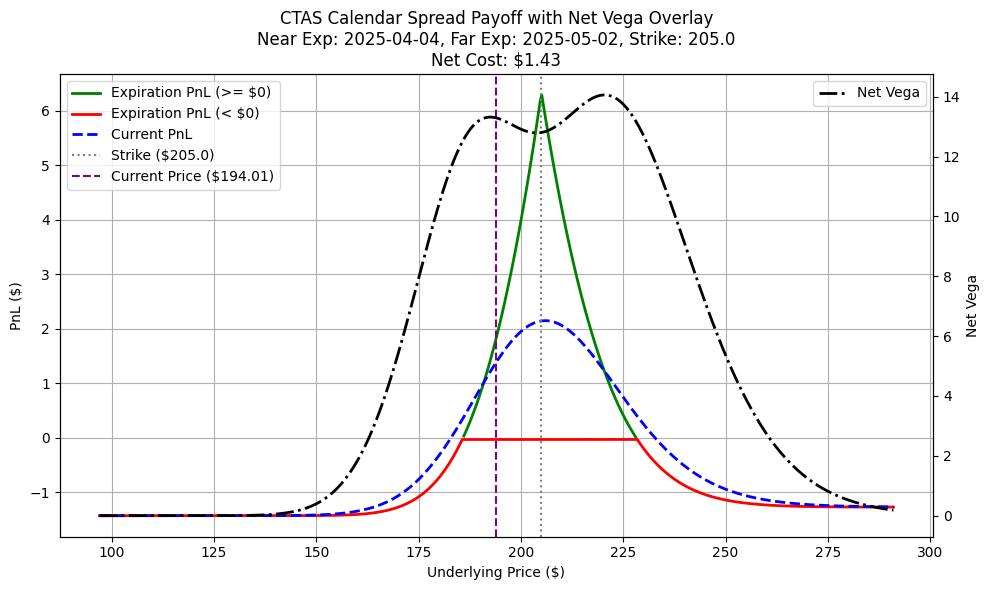

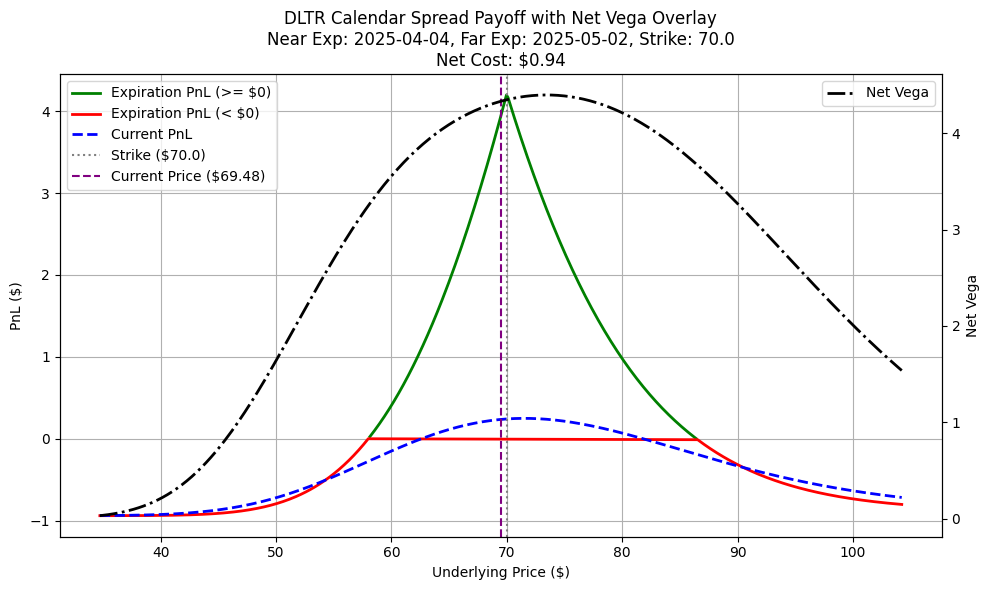

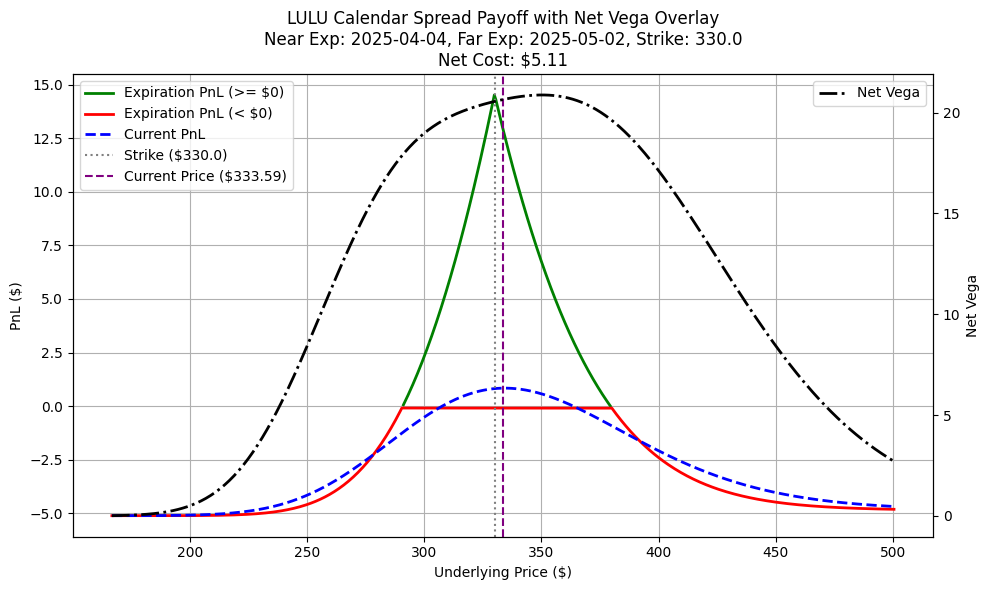

In [11]:
plot_calendar_spread(df)

In [22]:
API_KEY = str(os.getenv("APCA_PAPER_KEY_ID")).strip('"')
API_SECRET = str(os.getenv("APCA_PAPER_SECRET_KEY")).strip('"')
BASE_URL = "https://paper-api.alpaca.markets/v2"

headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "APCA-API-KEY-ID": API_KEY,
    "APCA-API-SECRET-KEY": API_SECRET
}

print(API_KEY)
print(API_SECRET)

PK8Q8U1KR5K8VYCG1WFZ
jcRDo4yvItEYvxYY0el2K7QjLmFrSWNpn48xFIRw


In [63]:
def find_option_symbol(symbol, strike, expiration_date):
    url = f"{BASE_URL}/options/contracts?underlying_symbols={symbol}&expiration_date={expiration_date}"
    response = requests.get(url, headers=headers)
    
    response = response.json()
    for contract in response['option_contracts']:
        if float(contract['strike_price']) == strike:
            return contract


# Initialize the Alpaca API (replace with your own API credentials)
def trade_calendar_spread(long_symbol, short_symbol, qty):
    """
    Submits orders for a calendar spread.
    
    Parameters:
      - long_symbol: the option symbol for the far-term (long) leg (e.g., "AAPL220418C00150000")
      - short_symbol: the option symbol for the near-term (short) leg (e.g., "AAPL220318C00150000")
      - qty: quantity to trade (assumed equal for both legs)
    
    Note: Adjust the option symbol format and order parameters to match your broker’s requirements.
    """
    try:
        # Submit order for the calendar spread
        payload = {
            "type": "limit",
            "time_in_force": "day",
            "order_class": "mleg",
            "limit_price": "10",  # Adjust the limit price as needed
            "qty": str(qty),
            "legs": [
                {
                    "side": "buy",
                    "position_intent": "buy_to_open",
                    "symbol": long_symbol,
                    "ratio_qty": str(qty)
                },
                {
                    "side": "sell",
                    "position_intent": "sell_to_open",
                    "symbol": short_symbol,
                    "ratio_qty": str(qty)
                }
            ]
        }
        
        response = requests.post(f"{BASE_URL}/orders", json=payload, headers=headers)
        
        if response.status_code == 200:
            print("Order submitted successfully:", response.json())
        else:
            print("Error submitting order:", response.text)
        
    except Exception as e:
        print("Error submitting calendar spread orders:", e)

In [65]:
for i in range(len(df)):
    long_option_symbol = find_option_symbol(df.loc[i][0], df.loc[i][4]['strike'], df.loc[i][4]['expiry'])['symbol']
    short_option_symbol = find_option_symbol(df.loc[i][0], df.loc[i][3]['strike'], df.loc[i][3]['expiry'])['symbol']  # Near-term option symbol (short call)
    quantity = 1

    trade_calendar_spread(long_option_symbol, short_option_symbol, quantity)

C:\Users\champ\AppData\Local\Temp\ipykernel_30424\3618352361.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  long_option_symbol = find_option_symbol(df.loc[i][0], df.loc[i][4]['strike'], df.loc[i][4]['expiry'])['symbol']
C:\Users\champ\AppData\Local\Temp\ipykernel_30424\3618352361.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  short_option_symbol = find_option_symbol(df.loc[i][0], df.loc[i][3]['strike'], df.loc[i][3]['expiry'])['symbol']  # Near-term option symbol (short call)


Order submitted successfully: {'id': '8e2249d7-b110-42a5-a48f-b098ba2c4b5a', 'client_order_id': '143af5a2-5f36-487b-ba98-2a28c4be13e5', 'created_at': '2025-03-24T17:05:44.572224479Z', 'updated_at': '2025-03-24T17:05:44.573952189Z', 'submitted_at': '2025-03-24T17:05:44.572224479Z', 'filled_at': None, 'expired_at': None, 'canceled_at': None, 'failed_at': None, 'replaced_at': None, 'replaced_by': None, 'replaces': None, 'asset_id': '', 'symbol': '', 'asset_class': '', 'notional': None, 'qty': '1', 'filled_qty': '0', 'filled_avg_price': None, 'order_class': 'mleg', 'order_type': 'limit', 'type': 'limit', 'side': '', 'time_in_force': 'day', 'limit_price': '10', 'stop_price': None, 'status': 'pending_new', 'extended_hours': False, 'legs': [{'id': '69761547-f147-4ba6-b38b-abc031633fae', 'client_order_id': 'a3225be5-b9c6-43db-8297-d318cbda1a08', 'created_at': '2025-03-24T17:05:44.572224479Z', 'updated_at': '2025-03-24T17:05:44.573958299Z', 'submitted_at': '2025-03-24T17:05:44.572224479Z', 'fil

In [96]:
def get_calendar_positions():
    response = requests.get(f"{BASE_URL}/positions", headers=headers).json()

    #CREATE A list of dictionaries of positions. Each dictionary has the symbol of the options underlying stock as the key, and a short and long order trade under each key which i s its own dictionary
    calendar_positions = {}
    for position in response:
        ticker = position['symbol'].split('25')[0]
        if ticker not in calendar_positions:
            calendar_positions[ticker] = {}
        if position['side'] == 'long':
            calendar_positions[ticker]['long'] = position
        if position['side'] == 'short':
            calendar_positions[ticker]['short'] = position
    
    for ticker, data in calendar_positions.items():
        short = data["short"]
        long = data["long"]
        
        net = {}
        
        # Define numeric fields we want to sum.
        numeric_fields = [
            "qty", "market_value", "cost_basis", 
            "unrealized_pl", "unrealized_intraday_pl",
            "qty_available", "change_today"
        ]
        for field in numeric_fields:
            net[field] = float(short[field]) + float(long[field])
        
        # Calculate weighted average entry price if net quantity is nonzero.
        net_qty = net["qty"]
        if net_qty != 0:
            net["avg_entry_price"] = (
                float(short["avg_entry_price"]) * float(short["qty"]) +
                float(long["avg_entry_price"]) * float(long["qty"])
            ) / net_qty
        else:
            # When the net quantity is zero, a weighted average doesn't apply.
            net["avg_entry_price"] = None
        
        # For percentage fields, recalculate them from the net values.
        # Here we use cost_basis as a basis for the calculation.
        if net["cost_basis"] != 0:
            net["unrealized_plpc"] = net["unrealized_pl"] / net["cost_basis"]
            net["unrealized_intraday_plpc"] = net["unrealized_intraday_pl"] / net["cost_basis"]
        else:
            net["unrealized_plpc"] = 0
            net["unrealized_intraday_plpc"] = 0
            
        # For current and last day prices, we average the two.
        net["current_price"] = float(long["current_price"]) - float(short["current_price"])
        net["lastday_price"] = float(long["lastday_price"]) - float(short["lastday_price"])
        
        # For other fields that are common, we can copy from one side.
        net["asset_class"] = short["asset_class"]
        net["asset_marginable"] = short["asset_marginable"]
        net["exchange"] = short["exchange"]
        
        # For symbol, you might choose to use the underlying ticker.
        net["symbol"] = ticker
        # Asset id might not make sense for a combined (net) position.
        net["asset_id"] = None
        
        # Determine the overall position side based on net quantity.
        if net["qty"] > 0:
            net["side"] = "long"
        elif net["qty"] < 0:
            net["side"] = "short"
        else:
            net["side"] = "flat"
        
        # Finally, add the "net" key to the ticker’s dictionary.
        data["net"] = net
                
    return calendar_positions
    

In [97]:
calendar_positions = get_calendar_positions()
calendar_positions

{'CTAS': {'short': {'asset_id': 'f8aba111-19b5-400f-ad56-e44d382c0f17',
   'symbol': 'CTAS250404C00205000',
   'exchange': '',
   'asset_class': 'us_option',
   'asset_marginable': True,
   'qty': '-1',
   'avg_entry_price': '1.45',
   'side': 'short',
   'market_value': '-170',
   'cost_basis': '-145',
   'unrealized_pl': '-25',
   'unrealized_plpc': '-0.1724137931034483',
   'unrealized_intraday_pl': '-25',
   'unrealized_intraday_plpc': '-0.1724137931034483',
   'current_price': '1.7',
   'lastday_price': '1.35',
   'change_today': '0.2592592592592593',
   'qty_available': '-1'},
  'long': {'asset_id': 'bed6dcef-3eba-42d8-be84-d15c7c3a98f2',
   'symbol': 'CTAS250502C00205000',
   'exchange': '',
   'asset_class': 'us_option',
   'asset_marginable': True,
   'qty': '1',
   'avg_entry_price': '4.2',
   'side': 'long',
   'market_value': '323',
   'cost_basis': '420',
   'unrealized_pl': '-97',
   'unrealized_plpc': '-0.230952380952381',
   'unrealized_intraday_pl': '-97',
   'unrealiz

In [99]:
for ticker, net in calendar_positions.items():
    asset_class = net['net'].get('asset_class', 'N/A')
    print(f"Symbol: {ticker} ({asset_class})")
    print(f"Net Quantity: {net['net']['qty']}")
    print(f"Net Market Value: ${net['net']['market_value']:.2f}")
    print(f"Net Cost Basis: ${net['net']['cost_basis']:.2f}")
    print(f"Net Unrealized P/L: ${net['net']['unrealized_pl']:.2f} ({net['net']['unrealized_plpc']:.2%})")

Symbol: CTAS (us_option)
Net Quantity: 0.0
Net Market Value: $153.00
Net Cost Basis: $275.00
Net Unrealized P/L: $-122.00 (-44.36%)
Symbol: DLTR (us_option)
Net Quantity: 0.0
Net Market Value: $105.00
Net Cost Basis: $100.00
Net Unrealized P/L: $5.00 (5.00%)
Symbol: LULU (us_option)
Net Quantity: 0.0
Net Market Value: $358.00
Net Cost Basis: $595.00
Net Unrealized P/L: $-237.00 (-39.83%)
